In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load the location dataset
data_path = "location_data.csv"
df_reader = pd.read_csv(data_path, chunksize=100000)
df_reader # Iterator

In [ ]:
# Selected 500 random trips from each chunk(size = 100000)
all_samples = []
df_reader = pd.read_csv(data_path, chunksize=100000)

for df in df_reader:
    all_samples.append(df.sample(500)) 

sample_df = pd.concat(all_samples, axis=0)

> *Iterators in Python can only be used once. After exhausting an iterator by consuming all its elements, we need to create a new iterator to traverse the sequence again.*

In [4]:
# size of sample df
sample_df.shape

(166500, 2)

In [5]:
# Sample data
sample_df.head()

,pickup_latitude,pickup_longitude
58899,40.707073,-74.004875
63809,40.745430,-73.994255
69295,40.740387,-73.986908
47324,40.756012,-73.970650
89321,40.717903,-73.953346


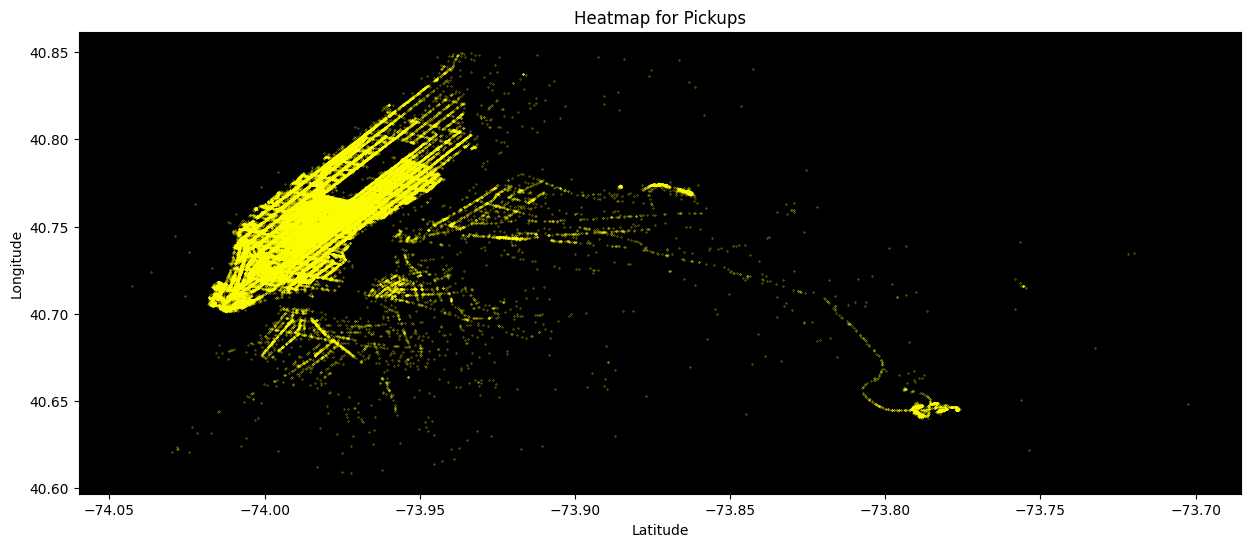

In [8]:
# plot the dataset on a scatterplot
fig, ax = plt.subplots(nrows=1,ncols=1,sharey=True,figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(sample_df['pickup_longitude'],sample_df['pickup_latitude'],s=0.05,color='yellow')
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.show()

In [10]:
from sklearn import set_config
set_config(transform_output = 'pandas')

In [11]:
# scale the input columns
from sklearn.preprocessing import StandardScaler
scale_samples = StandardScaler()
scaled_sample_df = scale_samples.fit_transform(sample_df)

> *Since clustering algorithms calculate distances between data points, we normalized all features to the same scale to ensure fair comparisons*

In [12]:
scaled_sample_df.head()

,pickup_latitude,pickup_longitude
58899,-1.609482,-0.836665
63809,-0.202703,-0.548481
69295,-0.387662,-0.349113
47324,0.185403,0.092065
89321,-1.212282,0.561606


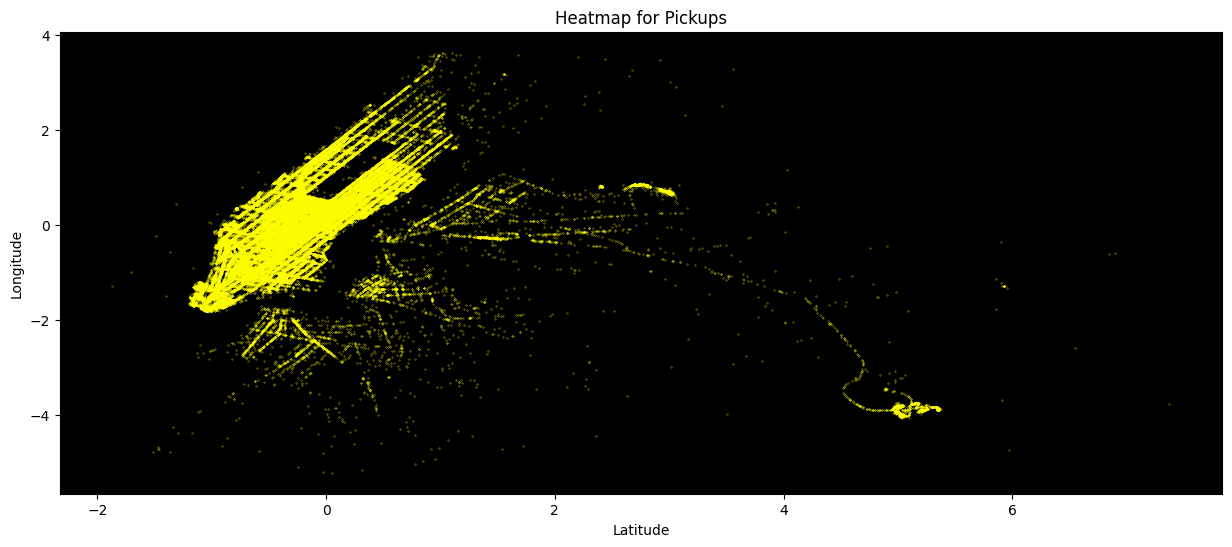

In [13]:
# plot the dataset on a scatterplot
fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(scaled_sample_df['pickup_longitude'],scaled_sample_df['pickup_latitude'],s=0.05,color='yellow')
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.show()

In [14]:
# Importing necessary libraries
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

In [15]:
# Loading the dataframe in chunks
df_reader = pd.read_csv(data_path, chunksize=100000)

In [16]:
# train the standard scaler
scaler = StandardScaler()

for chunk in df_reader:
    # fit the scaler
    scaler.partial_fit(chunk)

scaler

,copy,True
,with_mean,True
,with_std,True


In [17]:
# get the scaler std and mean
print("The mean values are ", scaler.mean_)
print("The sigma values are ", scaler.scale_ )

The mean values are  [ 40.75107121 -73.9740618 ]
The sigma values are  [0.02722268 0.03675237]


In [18]:
def haversine_distance(lat1:float, lon1:float, lat2:float, lon2:float):
    """
    Calculate haversine distances between two points given their latitude and
    longitude coordinates
    """
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(
        dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    
    earth_radius = 3958.8
    distance = earth_radius * c
    return distance

In [ ]:
def select_optimum_k(k_values):
    for k in k_values:
        df_reader = pd.read_csv(data_path, chunksize=100000)
        mini_batch = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)
        
        for chunk in df_reader:
            # scale the chunk
            scaled_chunk = scaler.transform(chunk)
            # train the model
            mini_batch.partial_fit(scaled_chunk)
            
        # centroid values
        centroids = scaler.inverse_transform(mini_batch.cluster_centers_) # getting the co-ordinates of centroids in original latitude and longiture scale
        # calculate distances
        all_distances = []
        for i in centroids:
            distances = []
            for j in centroids:
                distance = haversine_distance(i[0], i[1], j[0], j[1])
                distances.append(distance)
            all_distances.append(distances)
        all_distances = np.array(all_distances)
        # sort array
        sorted_distances = np.sort(all_distances, axis=-1)
        # nearby regions
        region_count = 8
        # selected distances
        selected_distances = sorted_distances[:, 1:region_count+1]
        # average distances
        avg_distances = selected_distances.mean(axis=1)
        # count averages that fit criteria
        counter = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).sum()
        percentage = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()
        print(f"For {k} clusters, the number of nearby regions that fits criteria are {counter} and is {percentage * 100:.1f}% regions of total")

In [20]:
possible_k_values = np.arange(10,100,10)
possible_k_values

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [21]:
# select the optimum value of K
select_optimum_k(k_values=possible_k_values)

For 10 clusters, the number of nearby regions that fits criteria are 0 and is 0.0% regions of total
For 20 clusters, the number of nearby regions that fits criteria are 6 and is 30.0% regions of total
For 30 clusters, the number of nearby regions that fits criteria are 9 and is 30.0% regions of total
For 40 clusters, the number of nearby regions that fits criteria are 8 and is 20.0% regions of total
For 50 clusters, the number of nearby regions that fits criteria are 7 and is 14.0% regions of total
For 60 clusters, the number of nearby regions that fits criteria are 10 and is 16.7% regions of total
For 70 clusters, the number of nearby regions that fits criteria are 13 and is 18.6% regions of total
For 80 clusters, the number of nearby regions that fits criteria are 14 and is 17.5% regions of total
For 90 clusters, the number of nearby regions that fits criteria are 17 and is 18.9% regions of total


> *Analysis of clustering results shows optimal performance with 30 clusters, satisfying the maximum number of evaluation criteria (30% of metrics)*

> ### `Clustering`

In [22]:
# Loading the dataframe
df_reader = pd.read_csv(data_path, chunksize=100000)

In [23]:
# train the model
mini_batch = MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

for chunk in df_reader:
    # scale the chunk
    scaled_chunk = scaler.transform(chunk)
    # train the model
    mini_batch.partial_fit(scaled_chunk)

In [24]:
# Model
mini_batch

,n_clusters,30
,init,'k-means++'
,max_iter,100
,batch_size,1024
,verbose,0
,compute_labels,True
,random_state,42
,tol,0.0
,max_no_improvement,10
,init_size,None
,n_init,10


In [25]:
# perform predictions and assign clusters
sample_predictions = mini_batch.predict(scaled_sample_df)

In [ ]:
# 30 Clusters
np.unique(sample_predictions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

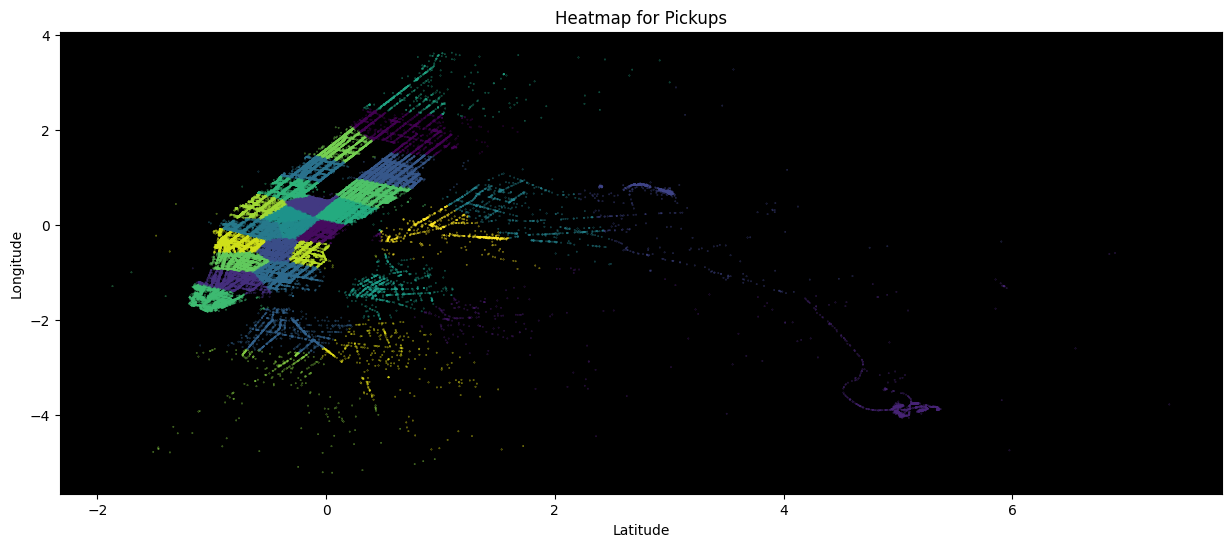

In [33]:
# plot the dataset on a scatterplot
fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,figsize=(15,6))

ax.set_facecolor('k')
scatter = ax.scatter(scaled_sample_df['pickup_longitude'],scaled_sample_df['pickup_latitude'],
                    s=0.05, c=sample_predictions)
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

plt.show()